# AWS Final Project

This following project is to solve and know how a company can retain their most valuable potential employees by analyzing what causes attrition in a this comapany. This will help us to understand what are the driving factors for people to leave and in the end make the necessary changes. 

The dataset was taken from: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

GitHub Repository: https://github.com/ByronB9/AWS-TeamA6

## How did we tackle this proplem?

We utilize AWS SageMaker for training two algorithms: the native XGBoost model and our custom Random Forest Classifier developed within the SageMaker notebook. This dual approach optimizes performance and flexibility for tailored machine learning solutions.

**Issue:**

We need to identify the key reasons for which employees choose to leave the company they work for.

**Goal:**

Offer solutions for companies to promptly recognise these factors and implement requisite adjustments to address them.





In [ ]:
# Install necessary libraries
!pip install --upgrade scikit-learn

!pip install --upgrade sagemaker

!pip install --upgrade s3fs

  Using cached botocore-1.34.75-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.34.75-py3-none-any.whl (12.1 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.51
    Uninstalling botocore-1.34.51:
      Successfully uninstalled botocore-1.34.51
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.1 requires botocore<1.34.52,>=1.34.41, but you have botocore 1.34.75 which is incompatible.
awscli 1.32.69 requires botocore==1.34.69, but you have botocore 1.34.75 which is incompatible.
  Using cached botocore-1.34.51-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.34.51-py3-none-any.whl (12.0 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.75
    Uninstalling botocore-1.34.75:
      Successfully uninstalled botocore-1.34.75
ERROR: pip's dependency resolver does no

## Preprocessing the 1st Model

There was a bucket created specifically for this final project, the bucket name is "awshrdataset", in this bucket we include our dataset to be processed. 

Below you will find the code use in the SageMaker Notebook instance to call the bucket and read it.

In [2]:
# Import necessary libraries
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import io
import s3fs
from sagemaker.amazon.amazon_estimator import get_image_uri

# Load the dataset from S3
bucket_name = 'awshrdataset'  
file_key = 'HR-Employee-Attrition.csv'  

# Get the execution role for the notebook instance (this provides necessary permissions)
role = get_execution_role()

# Create a S3 client
s3_client = boto3.client('s3')

# Get the object from S3
obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Read the object (which is of 'bytes' type) as a pandas dataframe
df = pd.read_csv(obj['Body'])


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Check if the data is loaded correctly:

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Lets do a sanity check for NAN values

In [4]:
# SUM ALL NAN VALUES
df.isnull().sum().sum()

0

There are some unnecessary columns, which are better to take away to optimize the model:

In [5]:
# DROP UNNECESSARY COLUMNS
df = df.drop(columns=['EmployeeCount', 'EmployeeNumber', 'Over18', 'JobRole','StandardHours'])

In order for SageMaker to read it as a classification task, the target variable needs to be in front of the dataset. Therefore, there is a need to do a label encoder for a 1 and 0. Where 1 is Yes and 0 is a No in Attrition of the employees.

Find below the code that perform that:

In [6]:
# First column is the target, rest are features
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
le = LabelEncoder()

df['Attrition'] = le.fit_transform(df['Attrition'])
df = pd.concat([df['Attrition'], df.drop('Attrition', axis=1)], axis=1)

df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,0,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,1,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,0,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,0,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


## Train, validation and test split for ML for the 1st Model

Divide the dataframe into train, validation and test splits. We use random state for reprocucibility of the outcome. Also the train accounts for the 80% of the dataset. Validation and Test account for 10% each giving us a 100% use of the whole dataset.

In [7]:
# TRAIN, VALIDATION, TEST SPLIT
from sklearn.model_selection import train_test_split
train, testval = train_test_split(df, train_size=0.8, random_state=1200)
val, test = train_test_split(testval, train_size=0.5, random_state=1200)

train.shape, val.shape, test.shape

((1176, 30), (147, 30), (147, 30))

To interface with SageMaker, we upload our data to S3. This is achieved by using .to_csv to convert the DataFrame to a CSV string held in a StringIO object, which is then directly uploaded to S3.

In [8]:
s3 = boto3.resource('s3')

def upload_to_s3(df, bucket, filename):
    
    placeholder = io.StringIO()
    df.to_csv(placeholder, header=False, index=False)
    object = s3.Object(bucket, filename)
    object.put(Body=placeholder.getvalue())

Upload the sets to the bucket:

In [9]:
upload_to_s3(train, 'awshrdataset', 'train.csv')
upload_to_s3(val, 'awshrdataset', 'val.csv')
upload_to_s3(test, 'awshrdataset', 'test.csv')

## Setting up the 1st model

Now, let's configure our model setup.

We employ the Estimator class from the sagemaker.estimator module. This class establishes the runtime environment for training jobs of a model.

We define the following parameters:

1. Container Name: SageMaker operates using containers. Here, we reference a pre-existing container containing all necessary components to execute XGBoost.
2. Role Name: Similar to Lambda functions, training jobs require a role with appropriate permissions. We previously created this role upon initiating the notebook server.
3. Number of Training Instances: In this case, we utilize one instance, although larger tasks may necessitate scaling with multiple instances.
4. Instance Type: We opt for an instance type included in the SageMaker payed tier.
5. Hyperparameters: We set is as a binary:logistic because it is a classification task of the Attrition column.



In [10]:
role = sagemaker.get_execution_role()
region_name = boto3.Session().region_name
container = sagemaker.image_uris.retrieve('xgboost', region_name, version='0.90-1')
output_location = 's3://awshrdataset/SageMakerOutput/'

hyperparams = {
    'num_round': '20',
    'objective': 'binary:logistic'
    }


estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=output_location,
    hyperparameters=hyperparams,
    sagemaker_session=sagemaker.Session()
)

In [11]:
from sagemaker.inputs import TrainingInput

train_channel = TrainingInput(
    's3://awshrdataset/train.csv',
    content_type='text/csv'
)
val_channel = TrainingInput(
    's3://awshrdataset/val.csv',
    content_type='text/csv'
)
channels_for_training = {
    'train': train_channel,
    'validation': val_channel
}

estimator.fit(inputs=channels_for_training, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-04-02-10-33-36-164



2024-04-02 10:33:36 Starting - Starting the training job.
2024-04-02 10:33:51 Starting - Preparing the instances for training........
2024-04-02 10:34:34 Downloading - Downloading input data......
2024-04-02 10:35:09 Downloading - Downloading the training image.....
2024-04-02 10:35:39 Training - Training image download completed. Training in progress.....
2024-04-02 10:36:05 Uploading - Uploading generated training model.
2024-04-02 10:36:16 Completed - Training job completed


As we can see above, the training has been done successfully, it can also be seen in Training Jobs in SageMaker.

In [12]:
# Lets see the name of the training job
estimator._current_job_name

'sagemaker-xgboost-2024-04-02-10-33-36-164'

In [13]:
# Get the metrics
metrics = sagemaker.analytics.TrainingJobAnalytics(
    estimator.latest_training_job.job_name
)

# Display the metrics
metrics = metrics.dataframe()
print(metrics)

   timestamp       metric_name     value
0        0.0       train:error  0.012755
1        0.0  validation:error  0.156463


Because it is a classification task, we only have the train and validation errors.

**Low Training Error (1.28%):** Indicates good performance on familiar training data in the early stages.

**Higher Validation Error (15.65%):** Suggests the model isn't as effective on new, unseen data.

**Important to Monitor:** We need to watch how these errors change throughout training.

**Potential Adjustments Needed:** If the gap persists or widens, we might have to tweak our model or training approach.

Now we deploy the endpoint so it is ready:

In [14]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', serializer=sagemaker.serializers.CSVSerializer())

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-04-02-10-36-19-298
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-04-02-10-36-19-298
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-04-02-10-36-19-298


------!

## Preprocessing the 2nd Model 

This model will again read the dataset from the bucket in order to create our second model, the RandomForest model.

In [15]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

# Define your bucket name and file key based on the screenshot provided
bucket_name = 'awshrdataset'  # Replace with your bucket name
file_key = 'HR-Employee-Attrition.csv'  # Replace with your file key as seen in the screenshot

# Get the execution role for the notebook instance (this provides necessary permissions)
role = get_execution_role()

# Create a S3 client
s3_client = boto3.client('s3')

# Get the object from S3
obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Read the object (which is of 'bytes' type) as a pandas dataframe
df2 = pd.read_csv(obj['Body'])


In [16]:
df2.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [17]:
# DROP UNNECESSARY COLUMNS
df2 = df2.drop(columns=['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'])

## Tran, test split the 2nd Model

In [18]:
# TRAIN TEST SPLIT 
from sklearn.model_selection import train_test_split

# REMOVE DEFAULT AND CREDIT_SCORE COLUMNS
X = df2.drop(['Attrition'], axis=1)
y = df2['Attrition']

# SPLIT THE DATA
# I AM USING RANDOM STATE FOR REPRODUCIBILITY, BECAUSE MY COMMENTS CONTAIN VARIABLES AND WHEN I RUN THE CODE AGAIN, THE VARIABLES WILL BE OVERWRITTEN.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1200) 

Now we will create the necessary pipelines for the model to interact with the dataset

In [19]:
# SET UP THE NUMERICAL AND CATEGORICAL PIPELINE
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# NUMERICAL PIPELINE
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# CATEGORICAL PIPELINE
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# FULL PIPELINE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# FIT INTO RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier())])

# FIT THE MODEL
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalar...
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

We now created a simple hyperparameter tuning in order to use the least resources possible due to the free-tier account in AWS

In [25]:
# GRID SEARCH FOR HYPERPARAMETER TUNING
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth' : [7,8],
    'classifier__criterion' :['gini']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=10)
grid_search.fit(X_train, y_train)

# BEST PARAMETERS
best_parameters = grid_search.best_params_

# Accuracy score
score = grid_search.best_score_

print(best_parameters)
print(score)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
0.8579913451135954


In [26]:
# ON THE TEST SET
from sklearn.metrics import accuracy_score

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Feature importance
feature_importance = best_model.named_steps['classifier'].feature_importances_

# Calculate the generalization score of the whole model
generalization_score = accuracy_score(y_test, predictions)

generalization_score

0.8571428571428571

Now lets understand the feature importances of this model in order to give explainability of the business case:

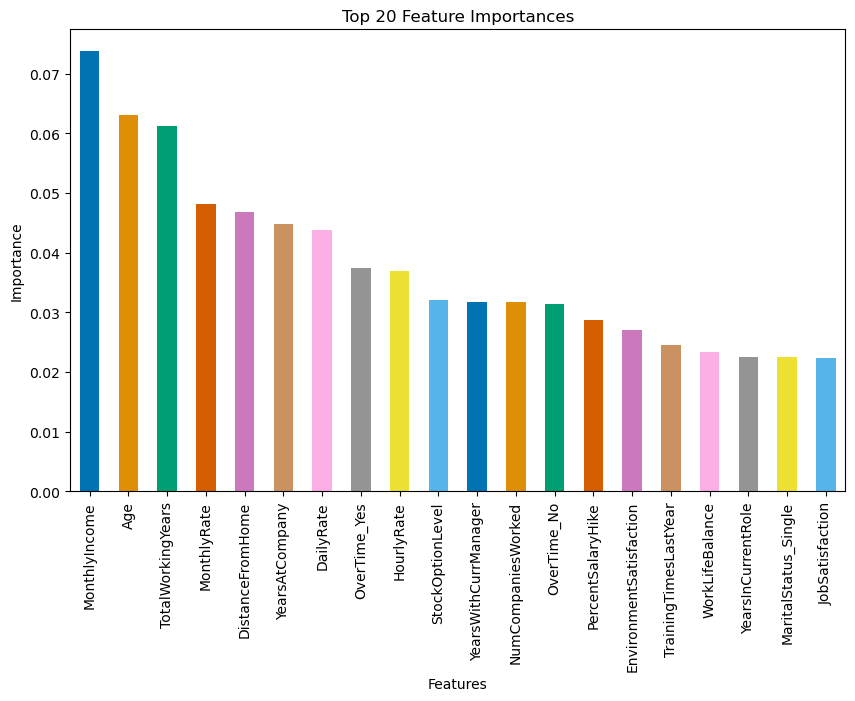

In [27]:
# Retrieve the best estimator
best_pipeline = grid_search.best_estimator_

# Extract the preprocessor and Random Forest classifier from the best estimator
preprocessor = best_pipeline.named_steps['preprocessor']
rf_classifier = best_pipeline.named_steps['classifier']

# Extracting feature names
# Numerical features
num_features = preprocessor.transformers_[0][2]

# Categorical features with one-hot encoding
cat_features_original = preprocessor.transformers_[1][2]
onehot_categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features_original)

# Combine feature names
all_features = num_features.tolist() + onehot_categories.tolist()

# Retrieve and plot feature importances
feature_importances = rf_classifier.feature_importances_
importances_series = pd.Series(feature_importances, index=all_features)
sorted_importances = importances_series.sort_values(ascending=False)

# Select top 15 features
top_15_features = sorted_importances.head(20)

# Custom color palette
import seaborn as sns
colors = sns.color_palette('colorblind', 20)

# Plotting
import matplotlib.pyplot as plt
top_15_features.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title("Top 20 Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

Lets print the metrics, in this case there are more metrics because the RandomForest model applies for more metrics than the XGB of the SageMaker built-in algorithm. 

## Metrics of the 2nd Model

In [28]:
# Evaluate other metrics
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

          No       0.86      1.00      0.92       246
         Yes       0.88      0.15      0.25        48

    accuracy                           0.86       294
   macro avg       0.87      0.57      0.59       294
weighted avg       0.86      0.86      0.81       294



array([[245,   1],
       [ 41,   7]])


This classification report shows performance metrics for a binary classification task, where the two classes are "No" and "Yes."

**Precision:** Measures the accuracy of positive predictions. For "No," it's 0.86, meaning 86% of items labeled as "No" are correct. For "Yes," it's 0.88, so 88% of items labeled as "Yes" are correct.

**Recall:** Measures the ability to find all positive instances. For "No," it's 1.00, indicating every "No" instance was identified correctly. However, for "Yes," it's only 0.15, suggesting only 15% of actual "Yes" instances were identified.

**F1-Score:** Harmonic mean of precision and recall, balancing the two. "No" has a high F1-score of 0.92, showing good balance. The F1-score for "Yes" is much lower at 0.25, reflecting poor recall.

**Support:** Number of actual occurrences of each class. There are 246 instances of "No" and 48 of "Yes."

**Accuracy:** Overall, 86% of predictions are correct.

**Macro Avg:** Average precision, recall, and F1-score without considering class imbalance. It's lower (0.59 for F1-score) due to the poor performance on "Yes."

**Weighted Avg:** Like macro average, but accounts for class imbalance. It's higher (0.81 for F1-score) because of the high proportion of "No" instances.

Overall, this model performs well in identifying "No" instances but struggles significantly with "Yes" instances, leading to imbalanced performance across classes.

Lets save this model as a tar file, in order to be deployed in the endpoint.

In [29]:
import boto3
import tarfile
import joblib
import os

# Specify the filename for your model
model_filename = 'modelhr.joblib'
# Dump your model using joblib
joblib.dump(best_model, model_filename)

# Specify the name for your tar file
tar_filename = 'modelhr.tar.gz'
# Create a tar file containing your model file
with tarfile.open(tar_filename, 'w:gz') as tar:
    tar.add(model_filename)

# Set your bucket name
bucket_name = 'awshrdataset'
# Set the path within the bucket where the tar file will be stored
# The trailing slash indicates it is stored in the folder
model_key = 'Model/' + tar_filename

# Get the SageMaker default execution role
from sagemaker import get_execution_role
role = get_execution_role()

# Use boto3 to upload your tar file to the bucket
s3 = boto3.resource('s3')
s3.Bucket(bucket_name).upload_file(tar_filename, model_key)

print(f'Model successfully uploaded as tar file to: s3://{bucket_name}/{model_key}')

Model successfully uploaded as tar file to: s3://awshrdataset/Model/modelhr.tar.gz


 The deployment of this algorithm built by us will incurr to more costs as shown in AWS SageMaker, because we will need a limit increase for Amazon SageMaker ml.m5.large for transform job usage under US East (Northern Virginia) to 1.0.

This is one of the limitations of the free-tier intance.

We leave it as a tar.gz file in order to built it in future occassion. 